# Import library

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Setting parameter

In [3]:
# reference concentration and numbers, concentration in mM
r1_c = [0.0341 * (i+2) for i in range(9)] #mM
r1_n = [2, 3, 2, 1, 2, 2, 2, 1, 2]

r2_c = [0.0343 * (i+2) for i in range(9)] 
r2_n = [3, 3, 3, 3, 2, 2, 2, 2, 2]

r3_c = [0.0387*(i+2) for i in range(9)]
r3_n = [2, 2, 2, 2, 2, 2, 2, 2, 2]


# sample numbers and numbers of spectra for each sample
sample_num = 2
s_per_sam = [3, 2]

# spectrum fitting range
spectrum_low = 220
spectrum_high = 350

# input the path of files
ref_file = '2023-09-25_UV-Vis-reference.csv'
sample_file = '2023-09-19_sample.csv'

# Spectra processing

## Loading reference spectra

In [4]:
# read data
df_x_origin = pd.read_csv('data/' + ref_file)
df_x_origin = df_x_origin.set_index('Unnamed: 0')
df_x = df_x_origin.loc[str(spectrum_low):str(spectrum_high)]

# read reference of solvent
ref_solvent = np.load('bkg_spectrum.npy')
ref_solvent = pd.DataFrame(ref_solvent).set_index(0)
ref_solvent = ref_solvent.loc[str(spectrum_low):str(spectrum_high+1)]
df_x['bkg'] = ref_solvent

# create ref df
X = pd.DataFrame(index=df_x.index)

# get standard curve of reference1
pos = 0
for i in range(len(r1_n)):
    df_x[f'r1_{i+1}'] = df_x.iloc[:, pos:pos+r1_n[i]].sum(axis=1)/r1_n[i] - ref_solvent[1]
    pos += r1_n[i]
#X['r1'] = 0.5 * (df_x['r1_c1']/r1_c1 + df_x['r1_c2']/r1_c2)

# get standard curve of reference2
for i in range(len(r2_n)):
    df_x[f'r2_{i+1}'] = df_x.iloc[:, pos:pos+r2_n[i]].sum(axis=1)/r2_n[i] - ref_solvent[1] +0.0045
    pos += r2_n[i]
#X['r2'] = 0.5 * (df_x['r2_c1']/r2_c1 + df_x['r2_c2']/r2_c2)

# get standard curve of reference3
for i in range(len(r3_n)):
    df_x[f'r3_{i+1}'] = df_x.iloc[:, pos:pos+r3_n[i]].sum(axis=1)/r3_n[i] - ref_solvent[1]
    pos += r3_n[i]



# df_x['r3_c1'] = df_x.iloc[:, pos:pos+n31].sum(axis=1)/n31 - ref_solvent[1]
# pos += n31
# df_x['r3_c2'] = df_x.iloc[:, pos:pos+n32].sum(axis=1)/n32 - ref_solvent[1]
# pos += n32
#X['r3'] = 0.5 * (df_x['r3_c1']/r3_c1 + df_x['r3_c2']/r3_c2)

C:\Users\jyq19\AppData\Local\Temp\ipykernel_25096\1918553840.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['bkg'] = ref_solvent
C:\Users\jyq19\AppData\Local\Temp\ipykernel_25096\1918553840.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x[f'r1_{i+1}'] = df_x.iloc[:, pos:pos+r1_n[i]].sum(axis=1)/r1_n[i] - ref_solvent[1]
C:\Users\jyq19\AppData\Local\Temp\ipykernel_25096\1918553840.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

## Interpolate

In [5]:
#use spectrum at 0.2mM as standard reference

c1 = np.array([0] + r1_c)
f_r1 = interpolate.interp1d(c1, df_x[['bkg']+[f'r1_{i+1}' for i in range(len(r1_n))]], bounds_error=False, fill_value="extrapolate")
X['r1'] = f_r1(0.2)

c2 = np.array([0] + r2_c)
f_r2 = interpolate.interp1d(c2, df_x[['bkg']+[f'r2_{i+1}' for i in range(len(r2_n))]], bounds_error=False, fill_value="extrapolate")
X['r2'] = f_r2(0.2)

c3 = np.array([0] + r3_c)
f_r3 = interpolate.interp1d(c3, df_x[['bkg']+[f'r3_{i+1}' for i in range(len(r3_n))]], bounds_error=False, fill_value="extrapolate")
X['r3'] = f_r3(0.2)

## Loading sample spectra

In [6]:
df_y_origin = pd.read_csv('data/' + sample_file)
df_y_origin = df_y_origin.set_index('Unnamed: 0')

# selecting spectrum range
df_y = df_y_origin.loc[str(spectrum_low):str(spectrum_high)]

#substrate solvent
df_y = df_y.subtract(ref_solvent[1], axis=0)

y_pred = pd.DataFrame(index=df_x.index, columns=df_y.columns)
y_pred1 = pd.DataFrame(index=df_x.index, columns=df_y.columns)

# Fitting and plotting

## Linear regression

In [8]:
concentration = pd.DataFrame(columns=['ref1', 'ref2', 'ref3'])

# creating a regression model
model = LinearRegression(fit_intercept=False, positive=True)
for ind, col in df_y.items():
    model.fit(X, col)
    concentration.loc[ind] = model.coef_
    y_pred[ind] = model.predict(X)
real_concentration = 0.2*concentration
real_concentration

,ref1,ref2,ref3
0,0.173705,0.161229,0.167107
1,0.209421,0.172770,0.161886
2,0.185778,0.165445,0.168092
3,0.146061,0.473477,0.040834
4,0.165454,0.542805,0.044095


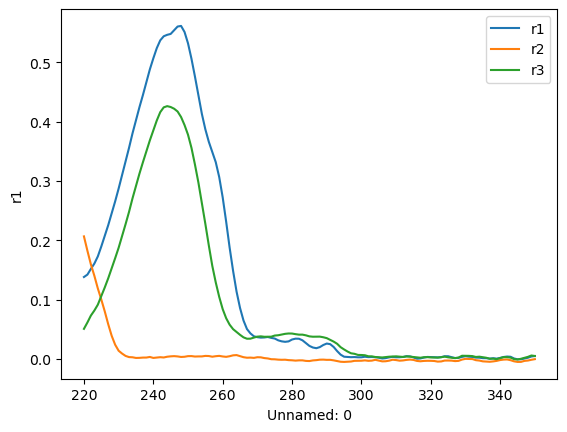

In [10]:
# plot reference
for ind, col in X.items():
    sns.lineplot(x=X.index, y=col, label=ind)
#sns.lineplot(x=X.index, y=f_r1(1), label=ind)
# for ind, col in X1.iteritems():
#     sns.lineplot(x=X1.index, y=col, label=ind)

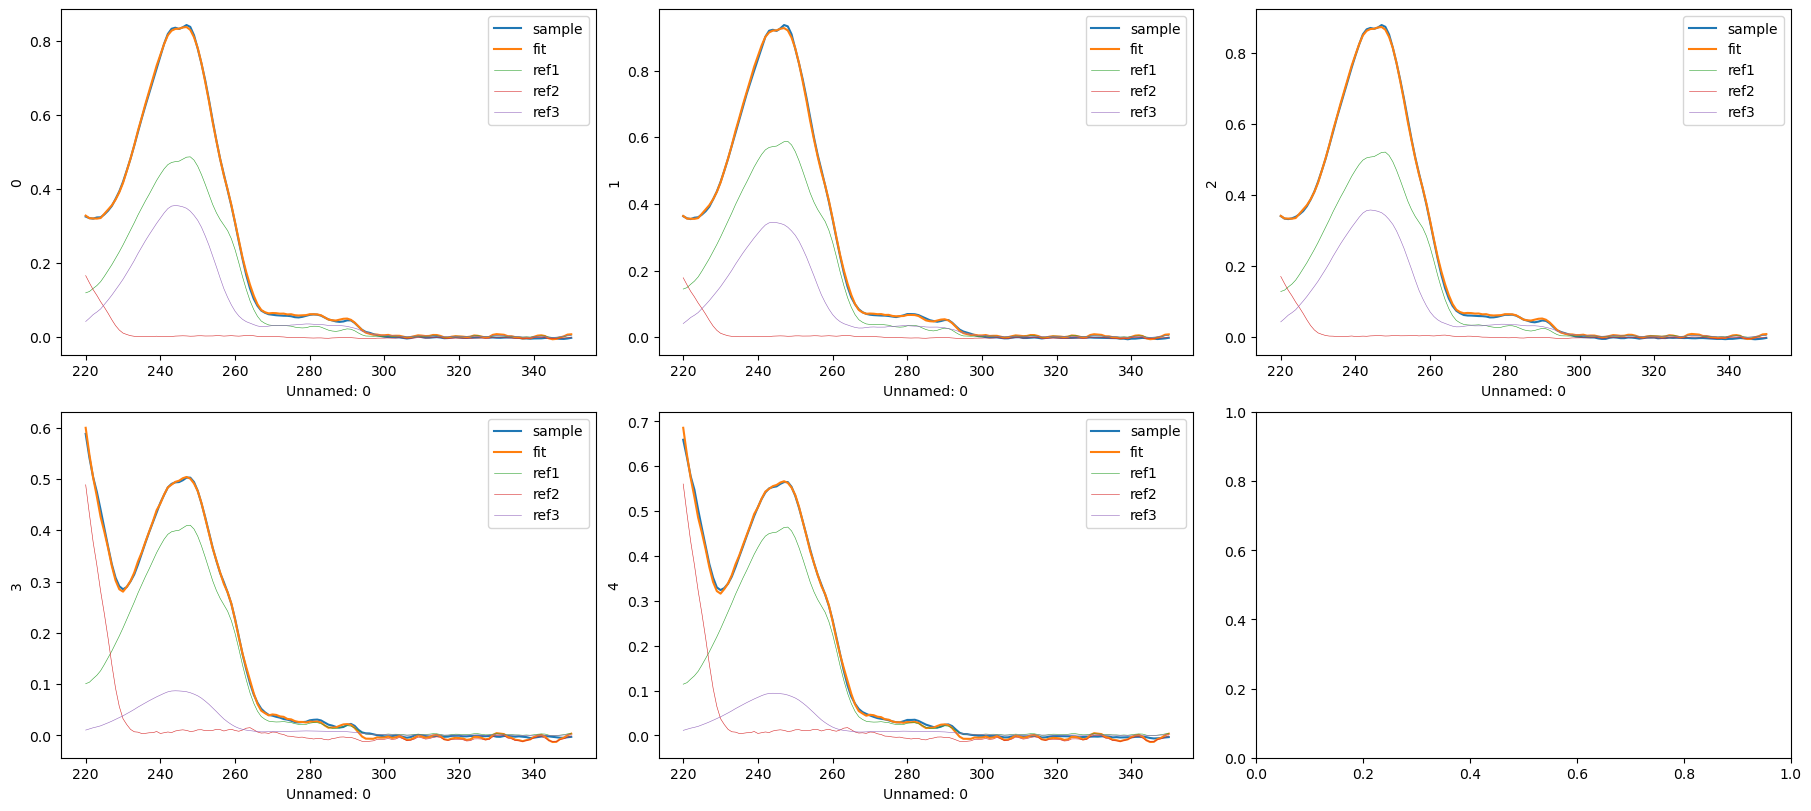

In [11]:
# plot figure
fig1, ax1 =plt.subplots(sample_num, max(s_per_sam), constrained_layout=True, figsize=(18, 8))
for i in range(len(df_y.columns)):
    if i < s_per_sam[0]:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]], label='sample', ax=ax1[0,i])
        axesSub = sns.lineplot(x=df_y.index, y=y_pred[y_pred.columns[i]], label='fit', ax=ax1[0,i])
        axesSub = sns.lineplot(x=df_y.index, y=X['r1']*concentration.iloc[i][0], label='ref1', ax=ax1[0,i], lw=0.4)
        axesSub = sns.lineplot(x=df_y.index, y=X['r2']*concentration.iloc[i][1], label='ref2', ax=ax1[0,i], lw=0.4)
        axesSub = sns.lineplot(x=df_y.index, y=X['r3']*concentration.iloc[i][2], label='ref3', ax=ax1[0,i], lw=0.4)
    else:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]], label='sample', ax=ax1[1,i-s_per_sam[0]])
        axesSub = sns.lineplot(x=df_y.index, y=y_pred[y_pred.columns[i]], label='fit', ax=ax1[1,i-s_per_sam[0]])
        axesSub = sns.lineplot(x=df_y.index, y=X['r1']*concentration.iloc[i][0], label='ref1', ax=ax1[1,i-s_per_sam[0]], lw=0.4)
        axesSub = sns.lineplot(x=df_y.index, y=X['r2']*concentration.iloc[i][1], label='ref2', ax=ax1[1,i-s_per_sam[0]], lw=0.4)
        axesSub = sns.lineplot(x=df_y.index, y=X['r3']*concentration.iloc[i][2], label='ref3', ax=ax1[1,i-s_per_sam[0]], lw=0.4)

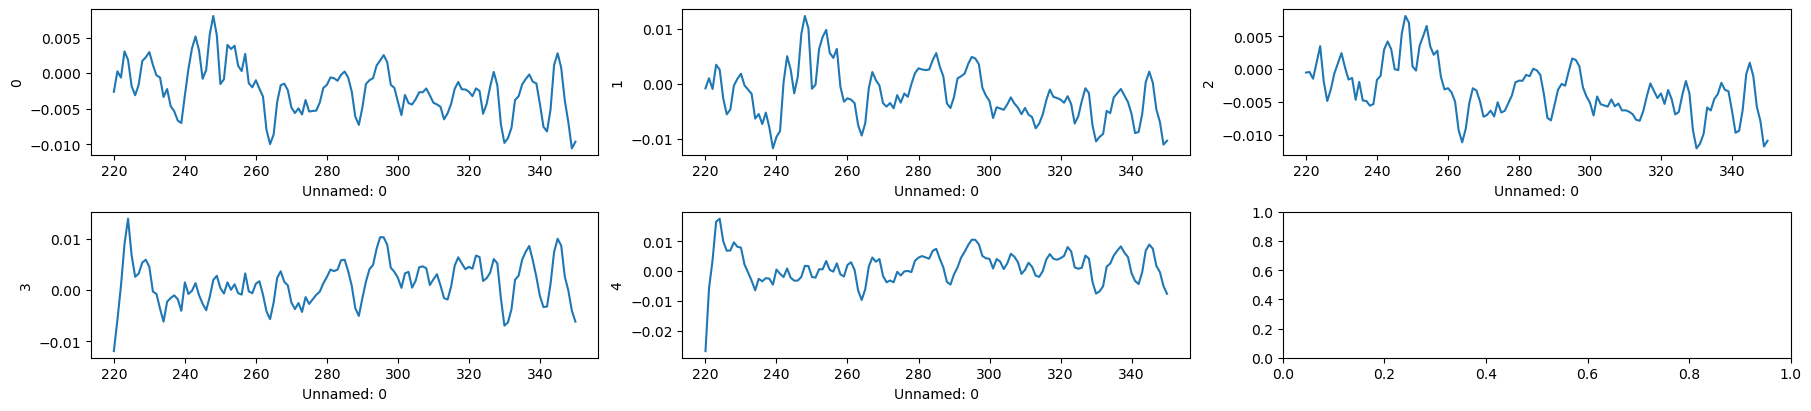

In [12]:
#plotting error
fig2, ax2 =plt.subplots(sample_num, max(s_per_sam), constrained_layout=True, figsize=(18, 4))
for i in range(len(df_y.columns)):
    if i < s_per_sam[0]:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]]-y_pred[y_pred.columns[i]], ax=ax2[0,i])
    else:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]]-y_pred[y_pred.columns[i]], ax=ax2[1,i-s_per_sam[0]])

## SVR

In [14]:
concentration2 = pd.DataFrame(columns=['ref1', 'ref2', 'ref3'])

# creating a regression model
model2 = SVR(epsilon=0.002, kernel='linear')
for ind, col in df_y.items():
    model2.fit(X, col)
    concentration2.loc[ind] = model2.coef_[0]
    y_pred1[ind] = model2.predict(X)
real_concentration2 = 0.2*concentration2
real_concentration2

,ref1,ref2,ref3
0,0.176124,0.158791,0.166214
1,0.210345,0.165812,0.162379
2,0.189575,0.161469,0.166074
3,0.153609,0.221216,0.032857
4,0.173793,0.226509,0.035775


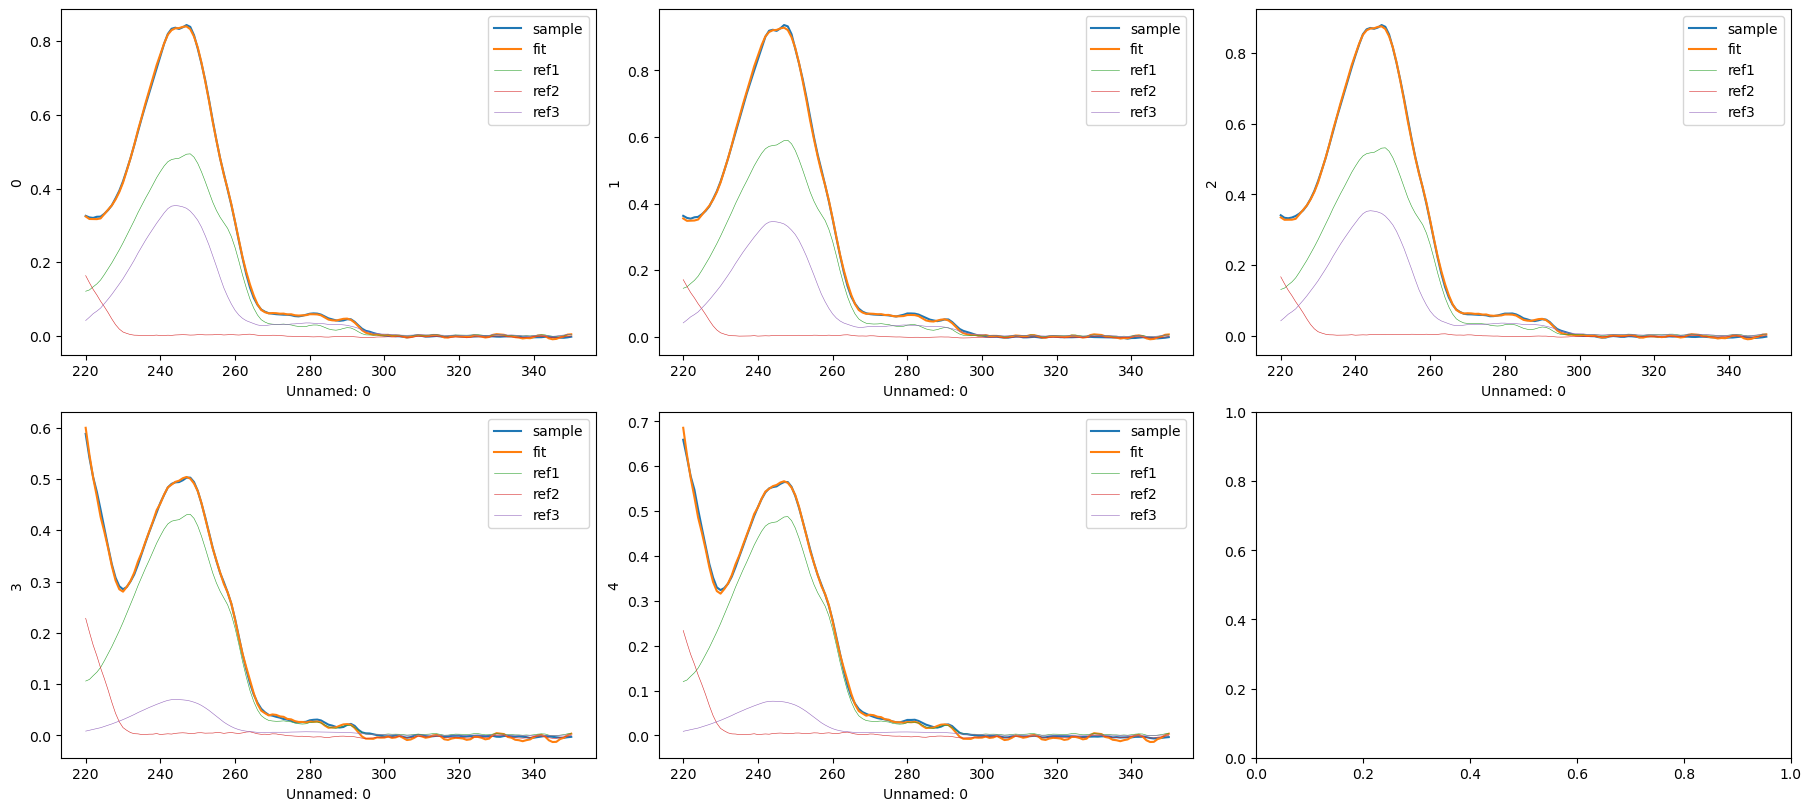

In [15]:
# plot figure
fig1, ax1 =plt.subplots(sample_num, max(s_per_sam), constrained_layout=True, figsize=(18, 8))
for i in range(len(df_y.columns)):
    if i < s_per_sam[0]:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]], label='sample', ax=ax1[0,i])
        axesSub = sns.lineplot(x=df_y.index, y=y_pred1[y_pred.columns[i]], label='fit', ax=ax1[0,i])
        axesSub = sns.lineplot(x=df_y.index, y=X['r1']*concentration2.iloc[i][0], label='ref1', ax=ax1[0,i], lw=0.4)
        axesSub = sns.lineplot(x=df_y.index, y=X['r2']*concentration2.iloc[i][1], label='ref2', ax=ax1[0,i], lw=0.4)
        axesSub = sns.lineplot(x=df_y.index, y=X['r3']*concentration2.iloc[i][2], label='ref3', ax=ax1[0,i], lw=0.4)
    else:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]], label='sample', ax=ax1[1,i-s_per_sam[0]])
        axesSub = sns.lineplot(x=df_y.index, y=y_pred[y_pred1.columns[i]], label='fit', ax=ax1[1,i-s_per_sam[0]])
        axesSub = sns.lineplot(x=df_y.index, y=X['r1']*concentration2.iloc[i][0], label='ref1', ax=ax1[1,i-s_per_sam[0]], lw=0.4)
        axesSub = sns.lineplot(x=df_y.index, y=X['r2']*concentration2.iloc[i][1], label='ref2', ax=ax1[1,i-s_per_sam[0]], lw=0.4)
        axesSub = sns.lineplot(x=df_y.index, y=X['r3']*concentration2.iloc[i][2], label='ref3', ax=ax1[1,i-s_per_sam[0]], lw=0.4)

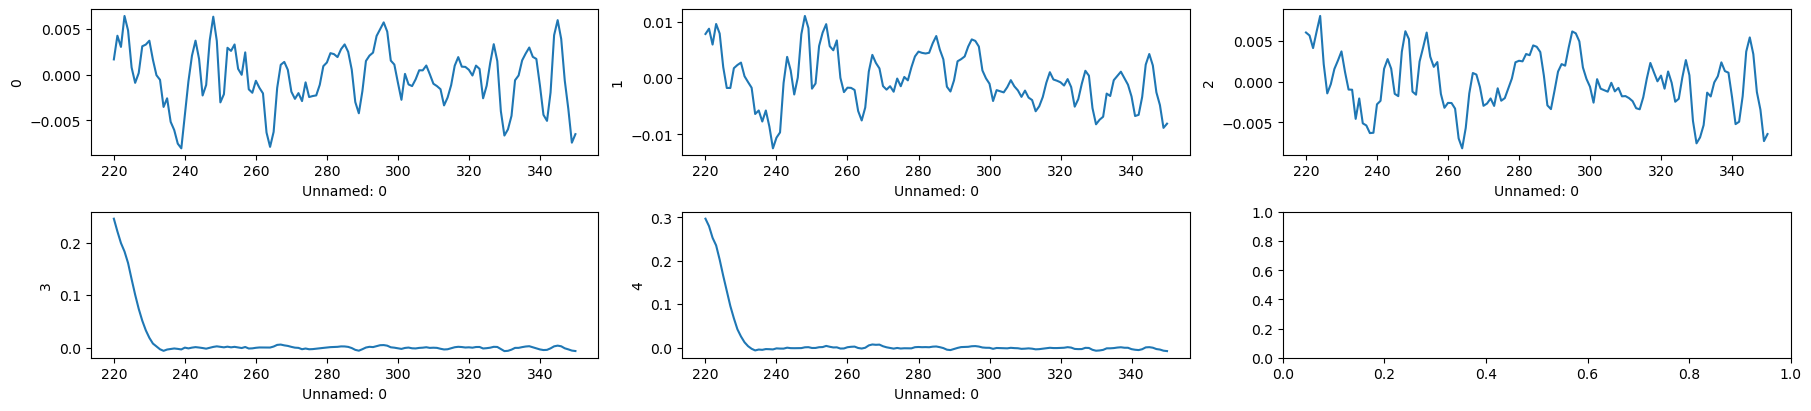

In [16]:
#plotting error
fig2, ax2 =plt.subplots(sample_num, max(s_per_sam), constrained_layout=True, figsize=(18, 4))
for i in range(len(df_y.columns)):
    if i < s_per_sam[0]:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]]-y_pred1[y_pred1.columns[i]], ax=ax2[0,i])
    else:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]]-y_pred1[y_pred1.columns[i]], ax=ax2[1,i-s_per_sam[0]])

## Comparison

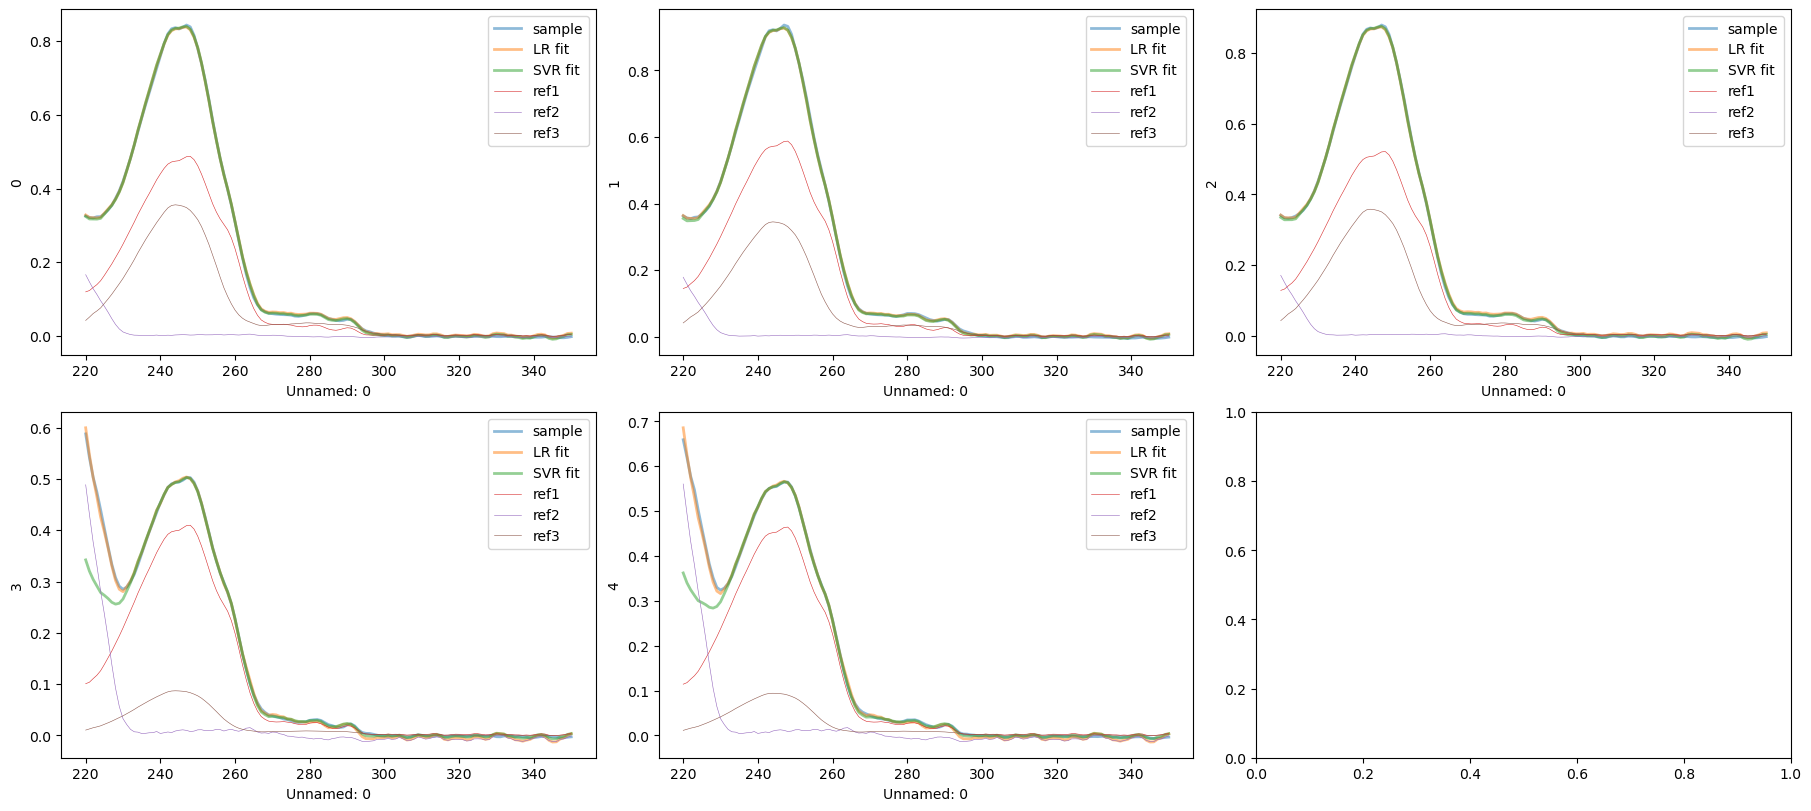

In [17]:
fig1, ax1 =plt.subplots(sample_num, max(s_per_sam), constrained_layout=True, figsize=(18, 8))
for i in range(len(df_y.columns)):
    if i < s_per_sam[0]:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]], label='sample', ax=ax1[0,i], alpha = 0.5, lw=2)
        axesSub = sns.lineplot(x=df_y.index, y=y_pred[y_pred.columns[i]], label='LR fit', ax=ax1[0,i], alpha = 0.5, lw=2)
        axesSub = sns.lineplot(x=df_y.index, y=y_pred1[y_pred.columns[i]], label='SVR fit', ax=ax1[0,i], alpha = 0.5, lw=2)
        axesSub = sns.lineplot(x=df_y.index, y=X['r1']*concentration.iloc[i][0], label='ref1', ax=ax1[0,i], lw=0.4)
        axesSub = sns.lineplot(x=df_y.index, y=X['r2']*concentration.iloc[i][1], label='ref2', ax=ax1[0,i], lw=0.4)
        axesSub = sns.lineplot(x=df_y.index, y=X['r3']*concentration.iloc[i][2], label='ref3', ax=ax1[0,i], lw=0.4)
    else:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]], label='sample', ax=ax1[1,i-s_per_sam[0]], alpha = 0.5, lw=2)
        axesSub = sns.lineplot(x=df_y.index, y=y_pred[y_pred.columns[i]], label='LR fit', ax=ax1[1,i-s_per_sam[0]], alpha = 0.5, lw=2)
        axesSub = sns.lineplot(x=df_y.index, y=y_pred1[y_pred.columns[i]], label='SVR fit', ax=ax1[1,i-s_per_sam[0]], alpha = 0.5, lw=2)
        axesSub = sns.lineplot(x=df_y.index, y=X['r1']*concentration.iloc[i][0], label='ref1', ax=ax1[1,i-s_per_sam[0]], lw=0.4)
        axesSub = sns.lineplot(x=df_y.index, y=X['r2']*concentration.iloc[i][1], label='ref2', ax=ax1[1,i-s_per_sam[0]], lw=0.4)
        axesSub = sns.lineplot(x=df_y.index, y=X['r3']*concentration.iloc[i][2], label='ref3', ax=ax1[1,i-s_per_sam[0]], lw=0.4)

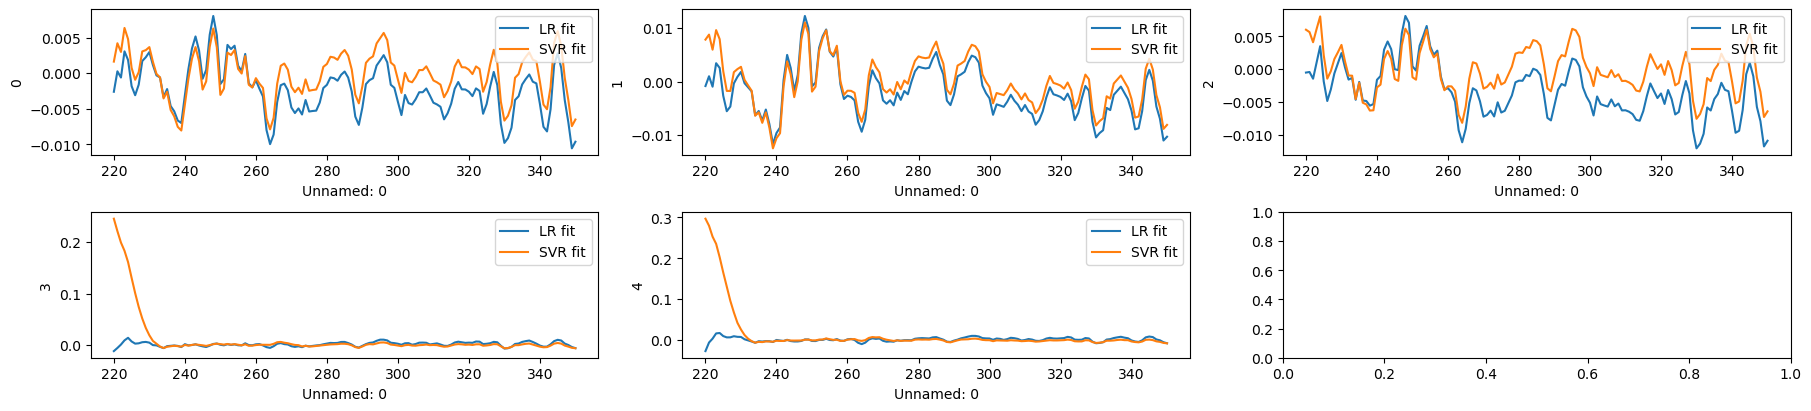

In [18]:
fig2, ax2 =plt.subplots(sample_num, max(s_per_sam), constrained_layout=True, figsize=(18, 4))
for i in range(len(df_y.columns)):
    if i < s_per_sam[0]:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]]-y_pred[y_pred.columns[i]], ax=ax2[0,i], label='LR fit')
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]]-y_pred1[y_pred1.columns[i]], ax=ax2[0,i], label='SVR fit')
    else:
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]]-y_pred[y_pred.columns[i]], ax=ax2[1,i-s_per_sam[0]], label='LR fit')
        axesSub = sns.lineplot(x=df_y.index, y=df_y[df_y.columns[i]]-y_pred1[y_pred1.columns[i]], ax=ax2[1,i-s_per_sam[0]], label='SVR fit')

# Export results